In [1]:
import pickle
import copy
import pandas as pd
from scipy import stats
from experiments import *
from utils import *

Definitions

In [2]:
scenarios = {'cnn':['summarization_cnndm:temperature=0.3,device=cuda,'], 
             'xsum':['summarization_xsum:temperature=0.3,device=cuda,'], 
             'boolq:':['boolq:'],
             'civil_comments':['civil_comments:demographic=LGBTQ,',
                               'civil_comments:demographic=all,',
                               'civil_comments:demographic=black,',
                               'civil_comments:demographic=christian,',
                               'civil_comments:demographic=female,',
                               'civil_comments:demographic=male,',
                               'civil_comments:demographic=muslim,',
                               'civil_comments:demographic=other_religions,',
                               'civil_comments:demographic=white,'],
             'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':['commonsense:dataset=hellaswag,method=multiple_choice_separate_original,'],
             'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':['commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,'],
             'imdb:':['imdb:'],
             'mmlu':['mmlu:subject=abstract_algebra,method=multiple_choice_joint,',
                     'mmlu:subject=college_chemistry,method=multiple_choice_joint,',
                     'mmlu:subject=computer_security,method=multiple_choice_joint,',
                     'mmlu:subject=econometrics,method=multiple_choice_joint,',
                     'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,'],
             'msmarco:track=regular,valid_topk=30,':['msmarco:track=regular,valid_topk=30,'],
             #'msmarco:track=trec,valid_topk=30,':['msmarco:track=trec,valid_topk=30,'],
             'narrative_qa:':['narrative_qa:'],
             'natural_qa:mode=closedbook,':['natural_qa:mode=closedbook,'],
             'natural_qa:mode=openbook_longans,':['natural_qa:mode=openbook_longans,'],
             'quac:':['quac:'],
             'raft':['raft:subset=ade_corpus_v2,',
                     'raft:subset=banking_77,',
                     'raft:subset=neurips_impact_statement_risks,',
                     'raft:subset=one_stop_english,',
                     'raft:subset=overruling,',
                     'raft:subset=semiconductor_org_types,',
                     'raft:subset=systematic_review_inclusion,',
                     'raft:subset=tai_safety_research,',
                     'raft:subset=terms_of_service,',
                     'raft:subset=tweet_eval_hate,',
                     'raft:subset=twitter_complaints,'],
             'truthful_qa:task=mc_single,method=multiple_choice_joint,':['truthful_qa:task=mc_single,method=multiple_choice_joint,']}
            
scenarios_metrics = {'boolq:':'em', 
                     'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':'em',
                     'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':'em',
                     'imdb:':'em', 
                     'mmlu':'em', 
                     'msmarco:track=regular,valid_topk=30,':'RR@10', 
                     'msmarco:track=trec,valid_topk=30,':'NDCG@10', 
                     'narrative_qa:':'f1', 
                     'natural_qa:mode=closedbook,':'f1', 
                     'natural_qa:mode=openbook_longans,':'f1', 
                     'quac:':'f1', 
                     'raft':'em', 
                     'truthful_qa:task=mc_single,method=multiple_choice_joint,':'em'}

## Data

Loading data

In [3]:
with open('data/helm.pickle', 'rb') as handle:
    data = pickle.load(handle)

## Results

In [4]:
device = 'cuda'
iterations = 3
Ds = [5, 10, 15] #

set_of_rows = [[0,1,2,3], #ai21
               [5,6,7,8,9,10,11], #cohere
               [4,12,13], #anthropic+microsoft
               [14,15,16,17,18,19,20,21,22], #openai
               [23,24,25,26,27]] #together
set_of_rows

[[0, 1, 2, 3],
 [5, 6, 7, 8, 9, 10, 11],
 [4, 12, 13],
 [14, 15, 16, 17, 18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27]]

In [5]:
data['models']

['ai21_j1-grande',
 'ai21_j1-grande-v2-beta',
 'ai21_j1-jumbo',
 'ai21_j1-large',
 'anthropic_stanford-online-all-v4-s3',
 'cohere_command-medium-beta',
 'cohere_command-xlarge-beta',
 'cohere_large-20220720',
 'cohere_medium-20220720',
 'cohere_medium-20221108',
 'cohere_xlarge-20220609',
 'cohere_xlarge-20221108',
 'microsoft_TNLGv2_530B',
 'microsoft_TNLGv2_7B',
 'openai_ada',
 'openai_babbage',
 'openai_curie',
 'openai_davinci',
 'openai_text-ada-001',
 'openai_text-babbage-001',
 'openai_text-curie-001',
 'openai_text-davinci-002',
 'openai_text-davinci-003',
 'together_bloom',
 'together_gpt-j-6b',
 'together_gpt-neox-20b',
 'together_opt-175b',
 'together_opt-66b']

### Predicting accuracy

Full (one IRT model for all scenarios)

In [6]:
scenario_name = 'full' #we are evaluating all scenarios at once
chosen_scenarios = list(scenarios.keys())
sampling = {'random_sampling':True,'anchor_sampling':True,
            'anchor-irt_sampling':True,'disc_sampling':False}
results_full, accs_full = evaluate_scenarios(data, scenario_name, chosen_scenarios, scenarios, set_of_rows, Ds, iterations, device, bench='irt_helm', sampling = sampling)


Evaluating models [0, 1, 2, 3]

i) choosing optimal D


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[11:57:15] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=5 lr=0.1                  
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path:                                                 cli.py:111
           data/irt_helm/rows-0:1:2:3_scenario-full_val.jsonlines               
           output directory:                                          cli.py:112
           models/irt_helm/rows-0:1:2:3_D-5_scenario-full_val/                  
[11:57:15] amortized: False                                       dataset.py:112
[11:57:16] Vocab size: None                                       training.py:90
[11:57:16] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 33%|██████████████▋                             | 1/3 [02:37<05:14, 157.45s/it]

[11:59:52] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=10 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path:                                                 cli.py:111
           data/irt_helm/rows-0:1:2:3_scenario-full_val.jsonlines               
           output directory:                                          cli.py:112
           models/irt_helm/rows-0:1:2:3_D-10_scenario-full_val/                 
[11:59:52] amortized: False                                       dataset.py:112
[11:59:53] Vocab size: None                                       training.py:90
[11:59:53] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 67%|█████████████████████████████▎              | 2/3 [05:46<02:55, 175.97s/it]

[12:03:02] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=15 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path:                                                 cli.py:111
           data/irt_helm/rows-0:1:2:3_scenario-full_val.jsonlines               
           output directory:                                          cli.py:112
           models/irt_helm/rows-0:1:2:3_D-15_scenario-full_val/                 
[12:03:02] amortized: False                                       dataset.py:112
[12:03:03] Vocab size: None                                       training.py:90
[12:03:03] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

100%|████████████████████████████████████████████| 3/3 [09:59<00:00, 199.74s/it]


- opt D= 5 errors= [0.04462662293667447, 0.04534021137127343, 0.04774267549873242] 


ii) choosing optimal lambdas


100%|████████████████████████████████████████| 15/15 [00:00<00:00, 71089.90it/s]


{'random_gpirt': {'cnn': {10: 0.5810980065561022, 25: 0.776185364418146, 50: 0.8739913974827889, 75: 0.9123110788518177, 100: 0.9327592417518723, 150: 0.9541450540563556}, 'xsum': {10: 0.12214799049569504, 25: 0.2580834196106841, 50: 0.4102802971372891, 75: 0.5106629684828556, 100: 0.5818422025325208, 150: 0.6760779593289555}, 'boolq:': {10: 0.10161491521841513, 25: 0.22043765726512518, 50: 0.36124361773481034, 75: 0.45896613338189834, 100: 0.5307552785238266, 150: 0.6291662607931963}, 'civil_comments': {10: 0.03457890877432671, 25: 0.0821844966189413, 50: 0.15188629457492606, 75: 0.2117485876802738, 100: 0.26371751324808634, 150: 0.3494926090000854}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.21291920659048225, 25: 0.40344593416830005, 50: 0.5749361971786783, 75: 0.6698451765235517, 100: 0.7301072871505678, 150: 0.8022841709410466}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.03920765730939187, 25: 0.09257

[12:07:16] amortized: False                                       dataset.py:112
[12:07:17] Vocab size: None                                       training.py:90
[12:07:17] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 24}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           20620, 'num_subjects': 24, 'priors': 'hierarchical',                 
           'dims': 5, 'dropout': 0.5, 'hidden': 100,                            
           'vocab_size': None}                                                  
torch.Size([494880]) torch.Size([494880])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 840420.7879 │ 840420.7879 │ 0.1000 │
│

 17%|███████▎                                    | 1/6 [03:23<16:56, 203.27s/it]/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:297: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|████████████████████████████████████████████| 6/6 [23:33<00:00, 235.50s/it]



iv) running random eval


100%|████████████████████████████████████████████| 6/6 [12:32<00:00, 125.42s/it]



v) running anchor points with IRT embeddings


100%|████████████████████████████████████████████| 6/6 [22:05<00:00, 220.97s/it]



Evaluating models [5, 6, 7, 8, 9, 10, 11]

i) choosing optimal D


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[13:08:49] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=5 lr=0.1                  
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path: data/irt_helm/rows-5:6:7:8:9:10:11_scenario-ful cli.py:111
           l_val.jsonlines                                                      
           output directory: models/irt_helm/rows-5:6:7:8:9:10:11_D-5 cli.py:112
           _scenario-full_val/                                                  
[13:08:50] amortized: False                                       dataset.py:112
[13:08:51] Vocab size: None                                       training.py:90
[13:08:51] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 33%|██████████████▋                             | 1/3 [01:45<03:31, 105.59s/it]

[13:10:35] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=10 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path: data/irt_helm/rows-5:6:7:8:9:10:11_scenario-ful cli.py:111
           l_val.jsonlines                                                      
           output directory: models/irt_helm/rows-5:6:7:8:9:10:11_D-1 cli.py:112
           0_scenario-full_val/                                                 
[13:10:35] amortized: False                                       dataset.py:112
[13:10:36] Vocab size: None                                       training.py:90
[13:10:36] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 67%|█████████████████████████████▎              | 2/3 [03:39<01:50, 110.75s/it]

[13:12:29] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=15 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path: data/irt_helm/rows-5:6:7:8:9:10:11_scenario-ful cli.py:111
           l_val.jsonlines                                                      
           output directory: models/irt_helm/rows-5:6:7:8:9:10:11_D-1 cli.py:112
           5_scenario-full_val/                                                 
[13:12:30] amortized: False                                       dataset.py:112
[13:12:30] Vocab size: None                                       training.py:90
[13:12:31] Training Model...                                          cli.py:116
[13:12:31] args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

100%|████████████████████████████████████████████| 3/3 [05:42<00:00, 114.01s/it]


- opt D= 5 errors= [0.05389249570423165, 0.05189495677110527, 0.05439960910911999] 


ii) choosing optimal lambdas


100%|████████████████████████████████████████| 15/15 [00:00<00:00, 72565.81it/s]


{'random_gpirt': {'cnn': {10: 0.6800790037019013, 25: 0.8416325599618499, 50: 0.9140070372987809, 75: 0.940979577879858, 100: 0.9550717625246664, 150: 0.9695924558955895}, 'xsum': {10: 0.14586503589811217, 25: 0.29919865575231325, 50: 0.46058954021786525, 75: 0.561559983113336, 100: 0.6306899064184214, 150: 0.7192294746100428}, 'boolq:': {10: 0.1425382279775365, 25: 0.2935767132258238, 50: 0.4538991931815538, 75: 0.5549117842038082, 100: 0.6243888094996332, 150: 0.7137533972552025}, 'civil_comments': {10: 0.03905972098434126, 25: 0.09224472276087652, 50: 0.1689085254222309, 75: 0.23363160332824376, 100: 0.2890021276236617, 150: 0.37877045740061055}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.19321110116989337, 25: 0.3744933454437555, 50: 0.5449183827410241, 75: 0.6423605406403432, 100: 0.705433230426347, 150: 0.7822405918129183}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.022525857650832985, 25: 0.05447403

[13:14:33] Vocab size: None                                       training.py:90
[13:14:33] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 21}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           20620, 'num_subjects': 21, 'priors': 'hierarchical',                 
           'dims': 5, 'dropout': 0.5, 'hidden': 100,                            
           'vocab_size': None}                                                  
torch.Size([433020]) torch.Size([433020])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 747594.2033 │ 747594.2033 │ 0.1000 │
│ 2000  │ 224276.9097 │ 224242.8015 │ 0.0819 │
└───────┴─────────────┴────────────

100%|████████████████████████████████████████████| 6/6 [34:39<00:00, 346.65s/it]



iv) running random eval


100%|████████████████████████████████████████████| 6/6 [21:17<00:00, 212.89s/it]



v) running anchor points with IRT embeddings


100%|████████████████████████████████████████████| 6/6 [30:54<00:00, 309.17s/it]



Evaluating models [4, 12, 13]

i) choosing optimal D


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[14:43:05] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=5 lr=0.1                  
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path:                                                 cli.py:111
           data/irt_helm/rows-4:12:13_scenario-full_val.jsonlines               
           output directory:                                          cli.py:112
           models/irt_helm/rows-4:12:13_D-5_scenario-full_val/                  
[14:43:05] amortized: False                                       dataset.py:112
[14:43:06] Vocab size: None                                       training.py:90
[14:43:06] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 33%|███████████████                              | 1/3 [01:34<03:08, 94.08s/it]

[14:44:39] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=10 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path:                                                 cli.py:111
           data/irt_helm/rows-4:12:13_scenario-full_val.jsonlines               
           output directory:                                          cli.py:112
           models/irt_helm/rows-4:12:13_D-10_scenario-full_val/                 
[14:44:40] amortized: False                                       dataset.py:112
[14:44:41] Vocab size: None                                       training.py:90
[14:44:41] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 67%|█████████████████████████████▎              | 2/3 [03:22<01:42, 102.29s/it]

[14:46:27] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=15 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path:                                                 cli.py:111
           data/irt_helm/rows-4:12:13_scenario-full_val.jsonlines               
           output directory:                                          cli.py:112
           models/irt_helm/rows-4:12:13_D-15_scenario-full_val/                 
[14:46:27] amortized: False                                       dataset.py:112
[14:46:29] Vocab size: None                                       training.py:90
[14:46:29] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

100%|████████████████████████████████████████████| 3/3 [05:15<00:00, 105.29s/it]


- opt D= 10 errors= [0.04024910356618192, 0.037689202864433106, 0.03712479012601339] 


ii) choosing optimal lambdas


100%|████████████████████████████████████████| 15/15 [00:00<00:00, 54096.78it/s]


{'random_gpirt': {'cnn': {10: 0.2715794190775654, 25: 0.4824239312122899, 50: 0.6508582613311908, 75: 0.7365821147348108, 100: 0.788508955101164, 150: 0.8483124506292552}, 'xsum': {10: 0.2833470942934764, 25: 0.49709296492559607, 50: 0.6640776178522768, 75: 0.747813367075591, 100: 0.7981329845771992, 150: 0.8557130654365214}, 'boolq:': {10: 0.14899051660003776, 25: 0.30443859597020734, 50: 0.4667733642820862, 75: 0.5676727798031007, 100: 0.6364628314757391, 150: 0.7242235587893543}, 'civil_comments': {10: 0.008348902948679956, 25: 0.020614099695106605, 50: 0.04039548287891528, 75: 0.05939360758913104, 100: 0.07765409124448619, 150: 0.11212755516675896}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.0270920533280044, 25: 0.06508519592184368, 50: 0.12221594323355832, 75: 0.1727665042144695, 100: 0.2178118105886194, 150: 0.294630693481803}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.017040616643927916, 25: 0.041

[14:48:22] amortized: False                                       dataset.py:112
[14:48:24] Vocab size: None                                       training.py:90
[14:48:24] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 25}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           20620, 'num_subjects': 25, 'priors': 'hierarchical',                 
           'dims': 10, 'dropout': 0.5, 'hidden': 100,                           
           'vocab_size': None}                                                  
torch.Size([515500]) torch.Size([515500])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss         ┃ Best Loss    ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 1252978.2744 │ 1252978.2744 │ 0.

100%|████████████████████████████████████████████| 6/6 [18:22<00:00, 183.75s/it]



iv) running random eval


100%|█████████████████████████████████████████████| 6/6 [08:39<00:00, 86.52s/it]



v) running anchor points with IRT embeddings


100%|████████████████████████████████████████████| 6/6 [18:13<00:00, 182.32s/it]



Evaluating models [14, 15, 16, 17, 18, 19, 20, 21, 22]

i) choosing optimal D


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[15:35:21] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=5 lr=0.1                  
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path: data/irt_helm/rows-14:15:16:17:18:19:20:21:22_s cli.py:111
           cenario-full_val.jsonlines                                           
           output directory: models/irt_helm/rows-14:15:16:17:18:19:2 cli.py:112
           0:21:22_D-5_scenario-full_val/                                       
[15:35:21] amortized: False                                       dataset.py:112
[15:35:22] Vocab size: None                                       training.py:90
[15:35:22] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 33%|███████████████                              | 1/3 [01:34<03:09, 94.57s/it]

[15:36:56] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=10 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path: data/irt_helm/rows-14:15:16:17:18:19:20:21:22_s cli.py:111
           cenario-full_val.jsonlines                                           
           output directory: models/irt_helm/rows-14:15:16:17:18:19:2 cli.py:112
           0:21:22_D-10_scenario-full_val/                                      
[15:36:56] amortized: False                                       dataset.py:112
[15:36:56] Vocab size: None                                       training.py:90
[15:36:57] Training Model...                                          cli.py:116
[15:36:57] args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 67%|█████████████████████████████▎              | 2/3 [03:28<01:46, 106.20s/it]

[15:38:50] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=15 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path: data/irt_helm/rows-14:15:16:17:18:19:20:21:22_s cli.py:111
           cenario-full_val.jsonlines                                           
           output directory: models/irt_helm/rows-14:15:16:17:18:19:2 cli.py:112
           0:21:22_D-15_scenario-full_val/                                      
[15:38:50] amortized: False                                       dataset.py:112
[15:38:51] Vocab size: None                                       training.py:90
[15:38:51] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

100%|████████████████████████████████████████████| 3/3 [05:25<00:00, 108.59s/it]


- opt D= 5 errors= [0.045918533119665865, 0.04510903717580774, 0.04698672038846964] 


ii) choosing optimal lambdas


100%|████████████████████████████████████████| 15/15 [00:00<00:00, 72733.60it/s]


{'random_gpirt': {'cnn': {10: 0.7893264856506694, 25: 0.9035373144834618, 50: 0.9493245103300146, 75: 0.9656358671333084, 100: 0.9740035641056983, 150: 0.9825175489309684}, 'xsum': {10: 0.7145113195727499, 25: 0.8622003906464604, 50: 0.9260017288978751, 75: 0.9494202136852479, 100: 0.9615793329819754, 150: 0.9740539335953974}, 'boolq:': {10: 0.10702135504182779, 25: 0.23054373347519364, 50: 0.3747022185454754, 75: 0.4733674171260726, 100: 0.5451394687380875, 150: 0.642565339268077}, 'civil_comments': {10: 0.0040268472962810995, 25: 0.010006675211174428, 50: 0.0198150674778109, 75: 0.029431012467722242, 100: 0.03886011907397521, 150: 0.05717918366801689}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.041670195611746445, 25: 0.09804703061222278, 50: 0.17858439188630393, 75: 0.24591802716214067, 100: 0.30304896809380394, 150: 0.39475795646407724}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.01387779422219853, 25:

[15:40:49] Vocab size: None                                       training.py:90
[15:40:49] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 19}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           20620, 'num_subjects': 19, 'priors': 'hierarchical',                 
           'dims': 5, 'dropout': 0.5, 'hidden': 100,                            
           'vocab_size': None}                                                  
torch.Size([391780]) torch.Size([391780])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 684278.8706 │ 684278.8706 │ 0.1000 │
│ 2000  │ 200940.3745 │ 200649.2954 │ 0.0819 │
└───────┴─────────────┴────────────

 83%|████████████████████████████████████▋       | 5/6 [33:46<07:07, 427.16s/it]/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! se

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 115 is empty! self.labels_[self.medoid_indices_[115]] may not be labeled with its corresponding cluster (115).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 116 is empty! self.labels_[self.medoid_indices_[116]] may not be labeled with its corresponding cluster (116).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 117 is empty! self.labels_[self.medoid_indices_[117]] may not be labeled with its corresponding cluster (117).
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 118 is empty! self.labels_[self.medoid_indices_[118]] may not be labeled with its corresponding 

100%|████████████████████████████████████████████| 6/6 [42:13<00:00, 422.22s/it]



iv) running random eval


100%|████████████████████████████████████████████| 6/6 [28:37<00:00, 286.17s/it]



v) running anchor points with IRT embeddings


100%|████████████████████████████████████████████| 6/6 [39:23<00:00, 393.94s/it]



Evaluating models [23, 24, 25, 26, 27]

i) choosing optimal D


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[17:32:37] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=5 lr=0.1                  
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path: data/irt_helm/rows-23:24:25:26:27_scenario-full cli.py:111
           _val.jsonlines                                                       
           output directory:                                          cli.py:112
           models/irt_helm/rows-23:24:25:26:27_D-5_scenario-full_val/           
[17:32:37] amortized: False                                       dataset.py:112
[17:32:38] Vocab size: None                                       training.py:90
[17:32:38] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 33%|███████████████                              | 1/3 [01:32<03:05, 92.94s/it]

[17:34:10] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=10 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path: data/irt_helm/rows-23:24:25:26:27_scenario-full cli.py:111
           _val.jsonlines                                                       
           output directory: models/irt_helm/rows-23:24:25:26:27_D-10 cli.py:112
           _scenario-full_val/                                                  
[17:34:10] amortized: False                                       dataset.py:112
[17:34:11] Vocab size: None                                       training.py:90
[17:34:11] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

 67%|██████████████████████████████               | 2/3 [03:16<01:39, 99.11s/it]

[17:35:53] config: model_type='multidim_2pl' epochs=2000              cli.py:109
           priors='hierarchical' initializers=[] dims=15 lr=0.1                 
           lr_decay=0.9999 dropout=0.5 hidden=100 vocab_size=None               
           log_every=2000 seed=42 deterministic=True                            
           data_path: data/irt_helm/rows-23:24:25:26:27_scenario-full cli.py:111
           _val.jsonlines                                                       
           output directory: models/irt_helm/rows-23:24:25:26:27_D-15 cli.py:112
           _scenario-full_val/                                                  
[17:35:53] amortized: False                                       dataset.py:112
[17:35:54] Vocab size: None                                       training.py:90
[17:35:54] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 1

100%|████████████████████████████████████████████| 3/3 [05:09<00:00, 103.02s/it]


- opt D= 10 errors= [0.04507936348364889, 0.03873258424955006, 0.04163312623660616] 


ii) choosing optimal lambdas


100%|████████████████████████████████████████| 15/15 [00:00<00:00, 72565.81it/s]


{'random_gpirt': {'cnn': {10: 0.5763562075573864, 25: 0.7727884169967134, 50: 0.8718337840969164, 75: 0.910742594774936, 100: 0.931529061505363, 150: 0.9532865360990304}, 'xsum': {10: 0.3324437914628914, 25: 0.5545662957114568, 50: 0.7134675404211773, 75: 0.78880715887661, 100: 0.8327762546885529, 150: 0.881936496018933}, 'boolq:': {10: 0.1294871424895145, 25: 0.2710681047647354, 50: 0.42652018998605573, 75: 0.5273232735663, 100: 0.5979868956361915, 150: 0.6905195287635474}, 'civil_comments': {10: 0.011289408953264891, 25: 0.027753540775587157, 50: 0.05400816377561324, 75: 0.07888210679212267, 100: 0.10248149043200577, 150: 0.14622933552335118}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.013332704094895106, 25: 0.03267822654983541, 50: 0.06328830357741334, 75: 0.09202054332545022, 100: 0.11904260277195008, 150: 0.16853262310473902}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.0067592341982302675, 25: 0.0167

[17:37:47] amortized: False                                       dataset.py:112
[17:37:48] Vocab size: None                                       training.py:90
[17:37:48] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 20620,          training.py:134
           'num_subjects': 23}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           20620, 'num_subjects': 23, 'priors': 'hierarchical',                 
           'dims': 10, 'dropout': 0.5, 'hidden': 100,                           
           'vocab_size': None}                                                  
torch.Size([474260]) torch.Size([474260])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss         ┃ Best Loss    ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 1175153.3358 │ 1175153.3358 │ 0.

 33%|██████████████▋                             | 2/6 [07:12<14:31, 217.79s/it]/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:297: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 50%|██████████████████████                      | 3/6 [11:14<11:25, 228.54s/it]/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:297: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 67%|█████████████████████████████▎              | 4/6 [15:34<08:01, 240.97s/it]/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:297: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|██


iv) running random eval


100%|████████████████████████████████████████████| 6/6 [14:23<00:00, 143.90s/it]



v) running anchor points with IRT embeddings


100%|████████████████████████████████████████████| 6/6 [24:25<00:00, 244.31s/it]


In [7]:
with open('results/results_full_helm.pickle', 'wb') as handle:
    pickle.dump(results_full, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('results/accs_full_helm.pickle', 'wb') as handle:
    pickle.dump(accs_full, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('results/results_full_helm.pickle', 'rb') as handle:
    results_full = pickle.load(handle)

with open('results/accs_full_helm.pickle', 'rb') as handle:
    accs_full = pickle.load(handle)

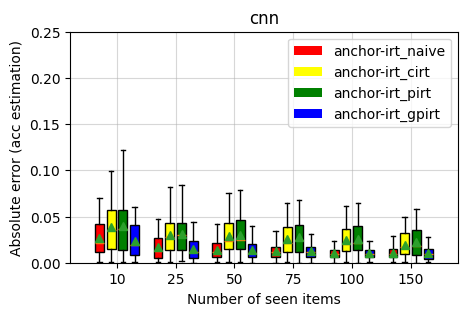

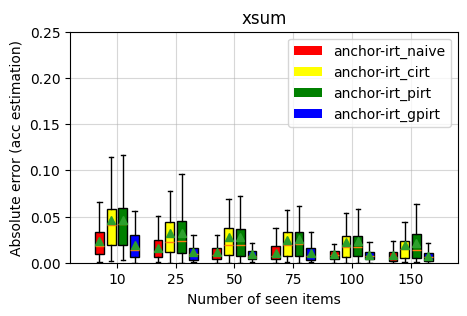

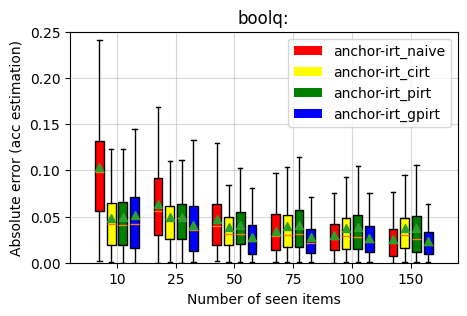

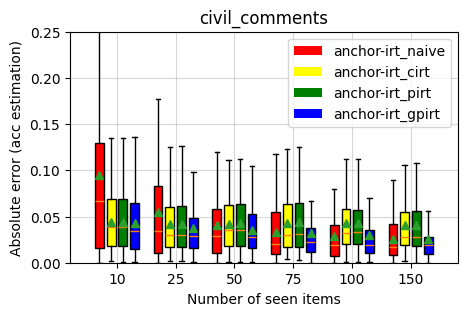

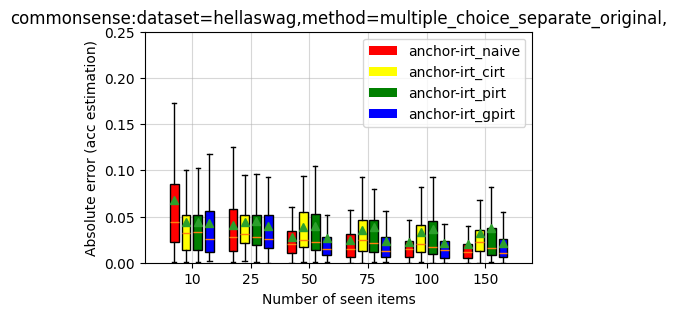

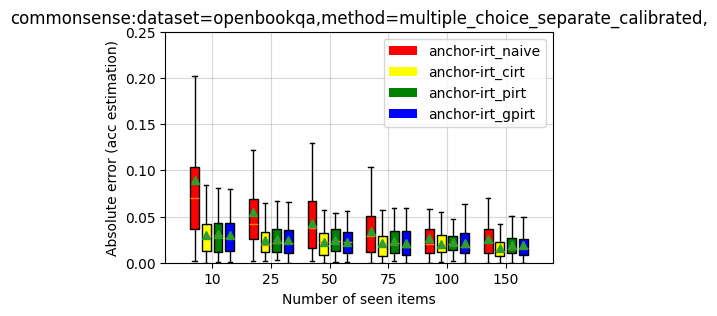

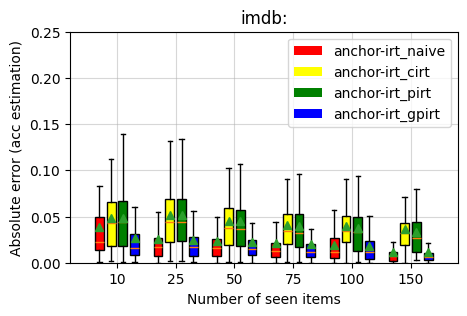

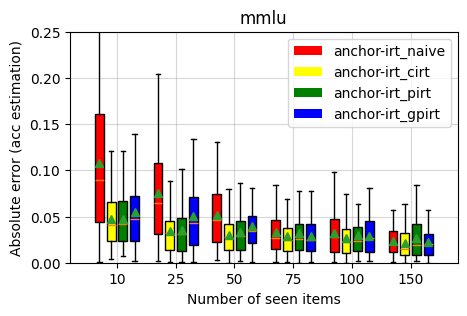

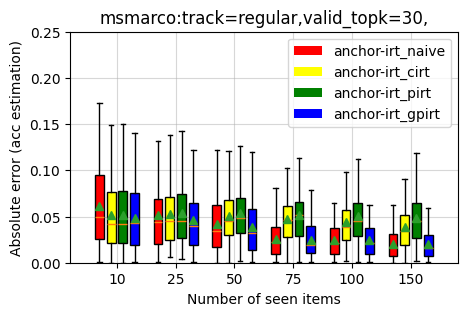

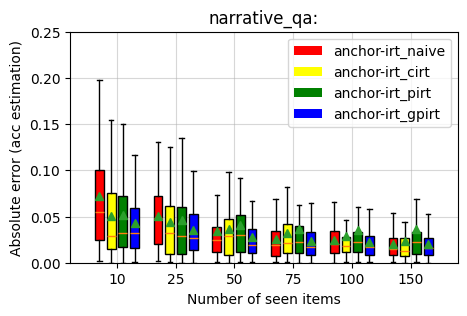

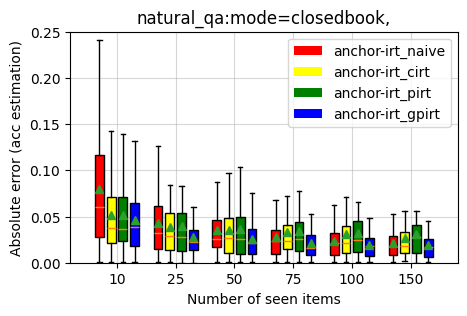

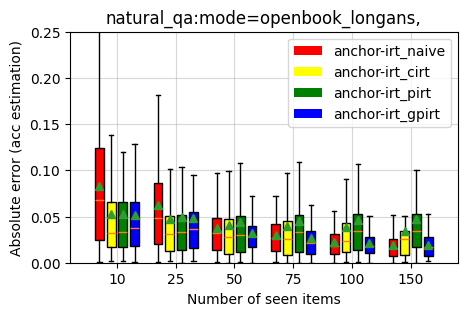

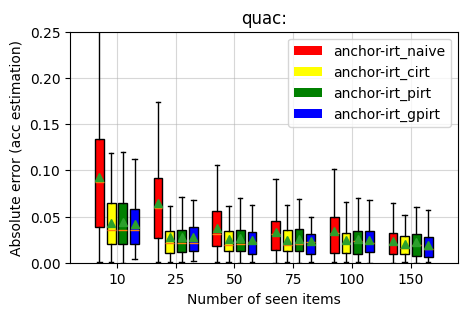

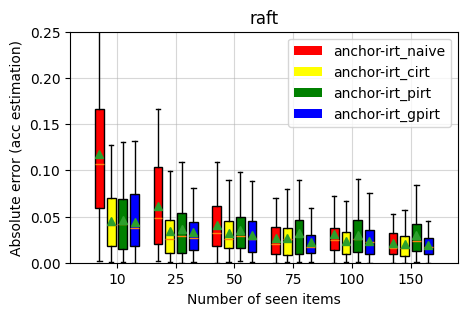

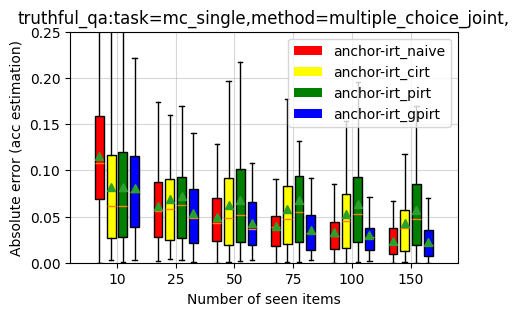

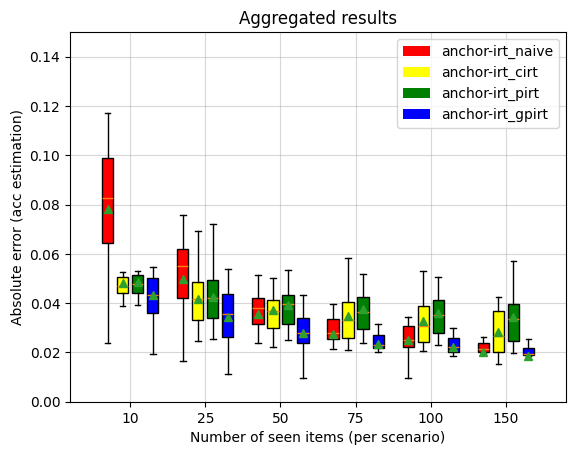

In [9]:
methods = ['anchor-irt_naive', 'anchor-irt_cirt', 'anchor-irt_pirt', 'anchor-irt_gpirt']
plot_results(results_full, scenarios.keys(), methods = methods)
plot_agg_results(results_full, scenarios.keys(), methods = methods)

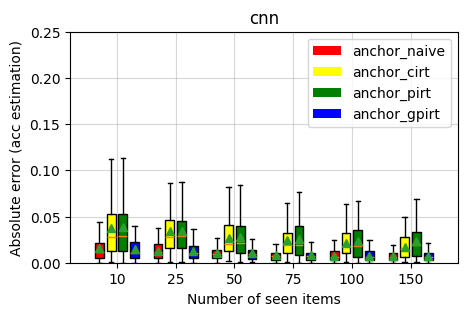

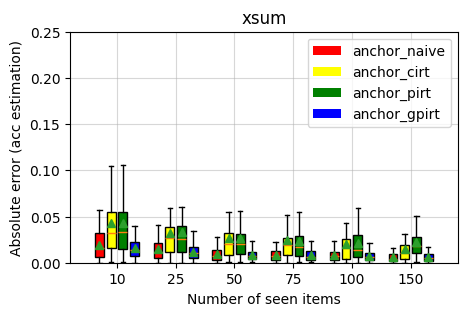

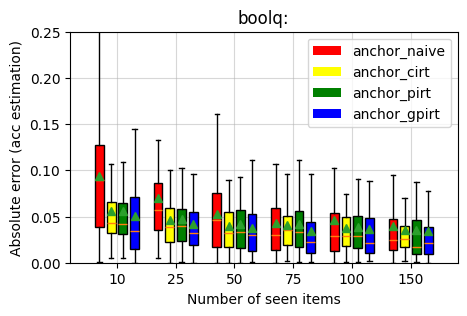

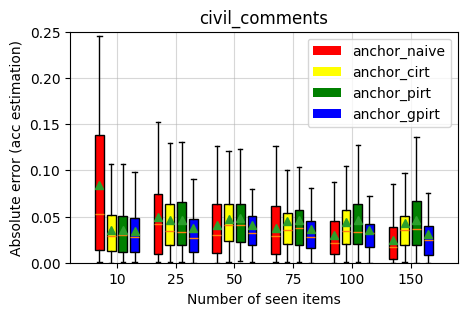

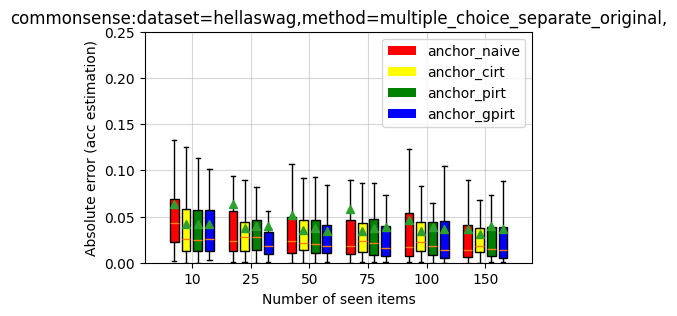

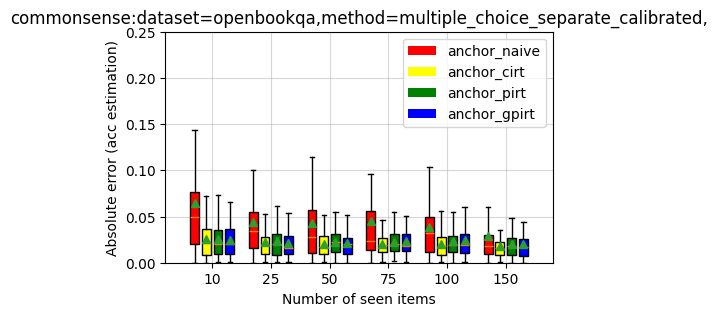

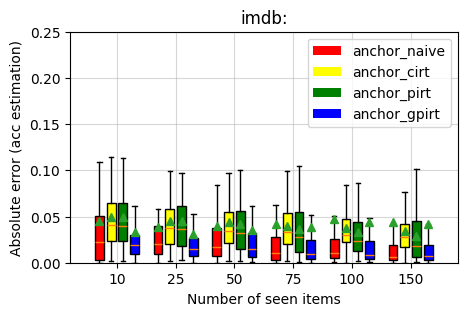

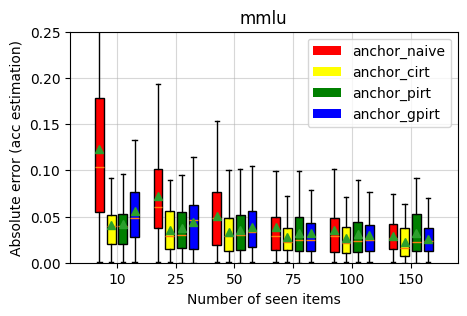

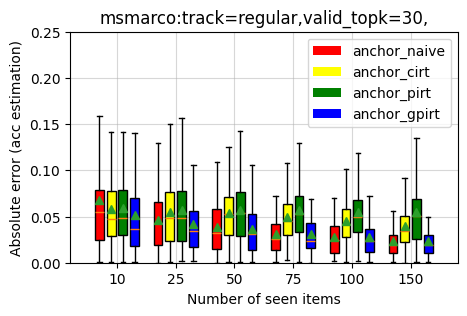

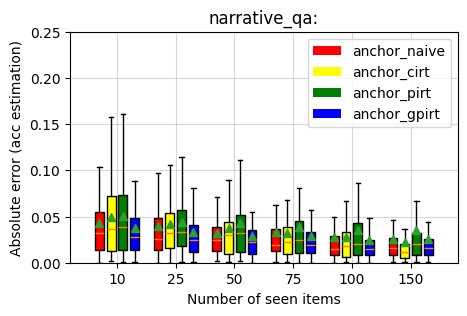

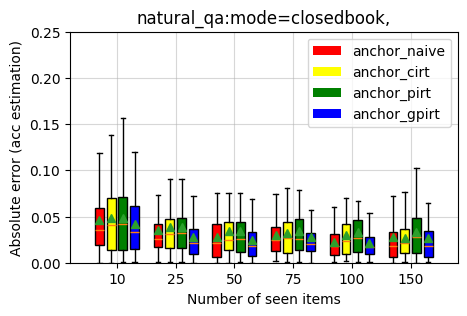

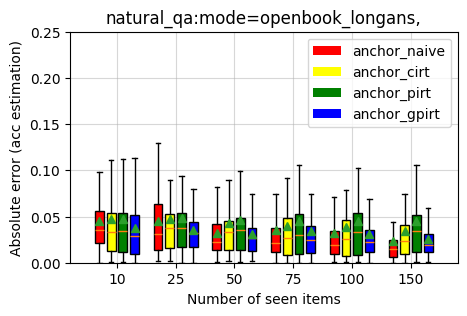

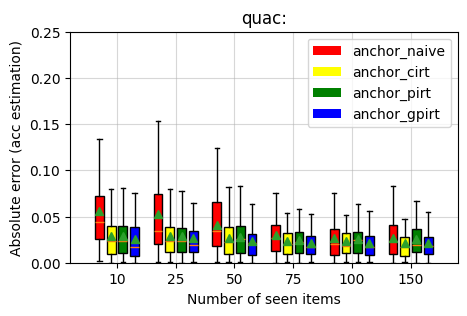

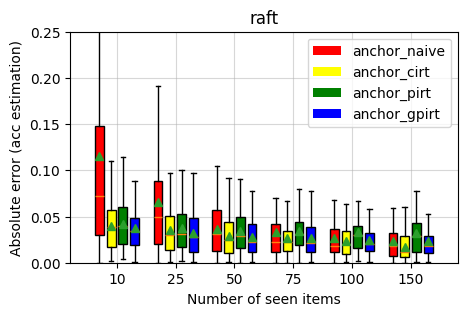

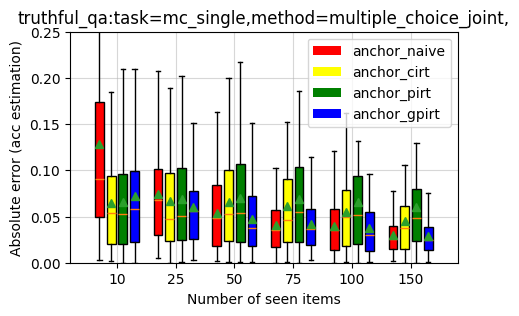

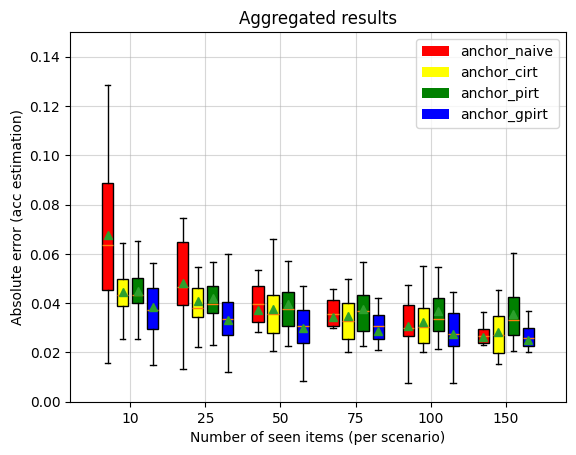

In [10]:
methods = ['anchor_naive', 'anchor_cirt', 'anchor_pirt', 'anchor_gpirt']
plot_results(results_full, scenarios.keys(), methods = methods)
plot_agg_results(results_full, scenarios.keys(), methods = methods)

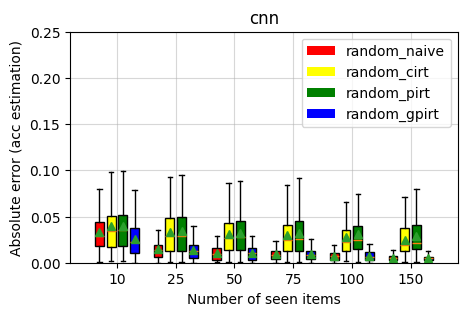

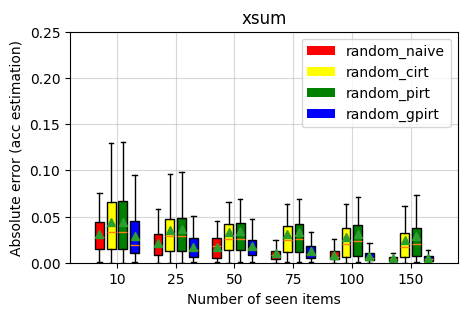

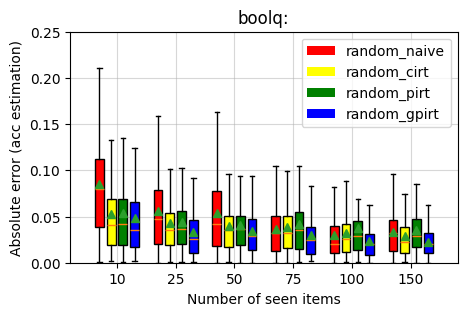

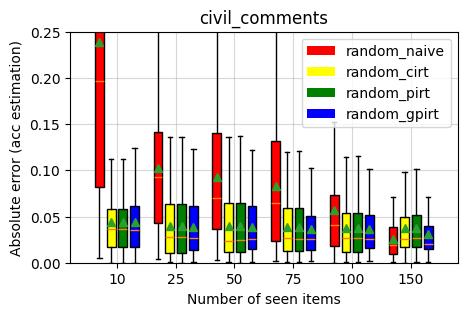

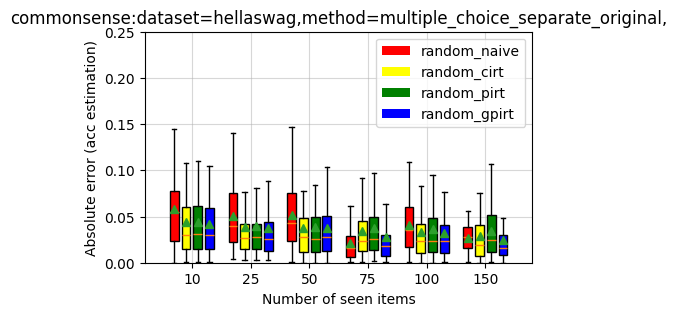

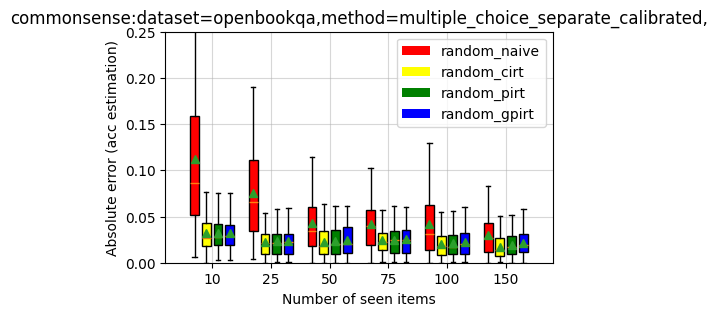

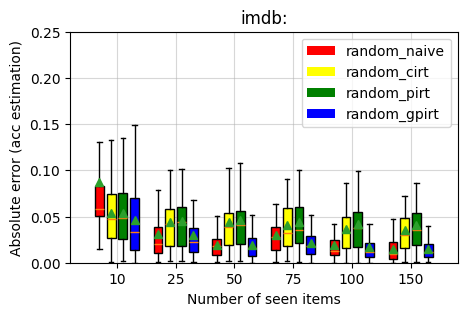

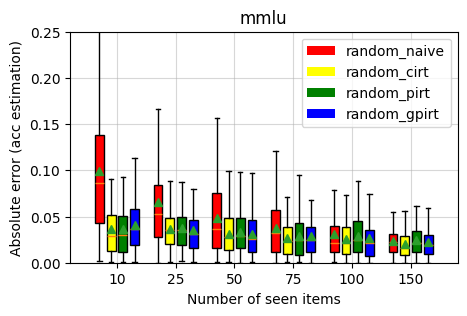

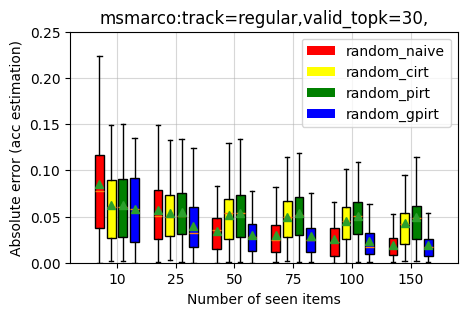

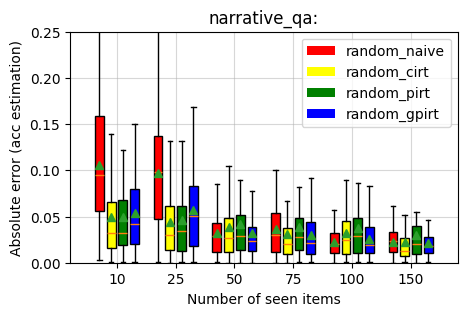

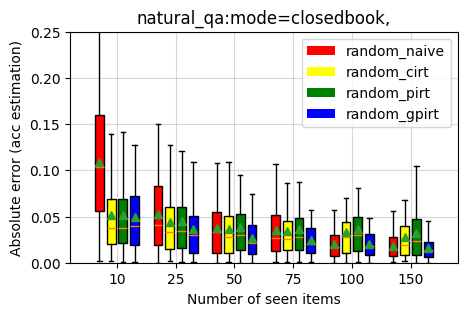

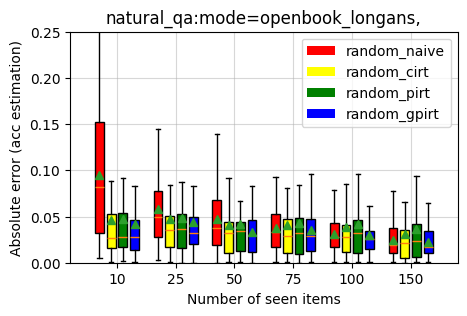

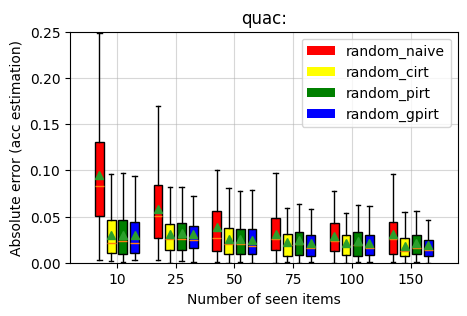

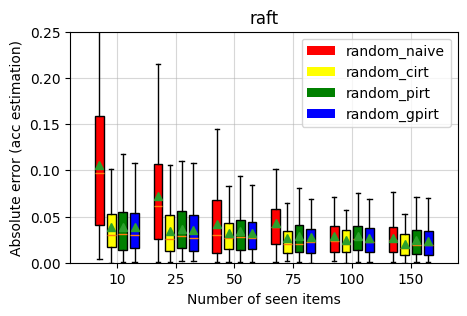

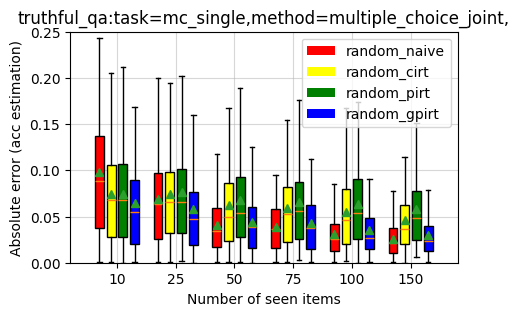

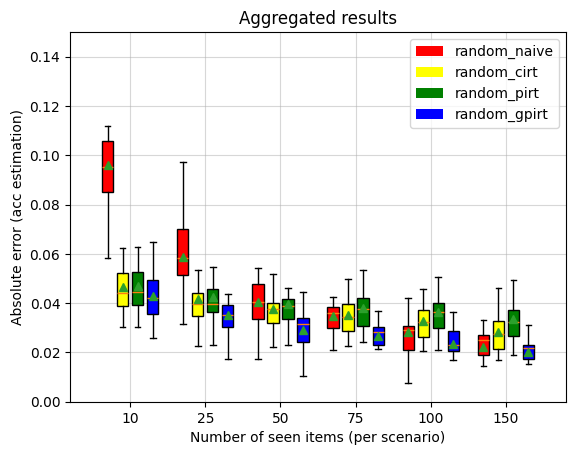

In [11]:
methods = ['random_naive', 'random_cirt', 'random_pirt', 'random_gpirt']
plot_results(results_full, scenarios.keys(), methods = methods)
plot_agg_results(results_full, scenarios.keys(), methods = methods)

In [12]:
chosen_scenarios = list(scenarios.keys())
models = accs_full.keys()
methods = ['random_naive','anchor_naive','anchor-irt_naive',
           #'random_cirt','anchor_cirt','anchor-irt_cirt',
           #'random_pirt','anchor_pirt','anchor-irt_pirt',
           'random_gpirt','anchor_gpirt','anchor-irt_gpirt']
iterations = 3

In [13]:
with open('data/helm.pickle', 'rb') as handle:
    data = pickle.load(handle)

scenarios_position, subscenarios_position = prepare_data(chosen_scenarios, scenarios, data)
scores = create_responses(chosen_scenarios, scenarios, data)
        
balance_weights = np.ones(scores.shape[1]) #for scenario in ['mmlu','civil_comments'], some items need to be up/downweighted, for other scenarios not
if 'civil_comments' in chosen_scenarios:
    balance_weights[scenarios_position['civil_comments']] = scores[:,scenarios_position['civil_comments']].max(axis=0)
    #(balance_weights==0).sum(axis=0) verifying that no item had weight 0 (the output should be zero)
    scores[:,scenarios_position['civil_comments']] = (scores[:,scenarios_position['civil_comments']]>0).astype(float)

if 'mmlu' in chosen_scenarios:
    N = len(scenarios_position['mmlu'])
    n_sub = len(scenarios['mmlu'])
    for sub in scenarios['mmlu']:
        n_i = len(subscenarios_position['mmlu'][sub])
        balance_weights[subscenarios_position['mmlu'][sub]] = N/(n_sub*n_i)
scores = balance_weights*scores

In [14]:
number_items = [10,25,50,75,100]
acc = np.vstack([scores[:,scenarios_position[scenario]].mean(axis=1) for scenario in chosen_scenarios])

In [15]:
table_avg = {}
table_std = {}

for s,scenario in enumerate(chosen_scenarios):
    table_avg[scenario]= {}
    table_std[scenario]= {}
        
    for method in methods:
        table_avg[scenario][method]= {}
        table_std[scenario][method]= {}

        for number_item in number_items:
            acc_hat = np.array([accs_full[model][number_item][method][scenario] for model in models])
            out = np.array([np.abs(acc[s]-acc_hat[:,i]).mean() for i in range(acc_hat.shape[1])]).mean(axis=0)
            table_avg[scenario][method][number_item] = np.round((100*out),2)
            table_std[scenario][method][number_item] = np.round((100*out),2)

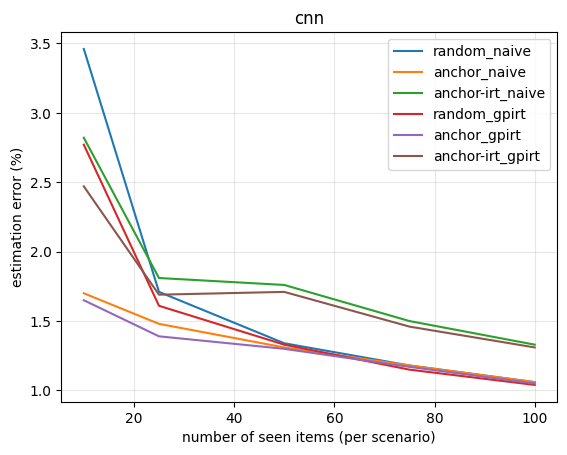

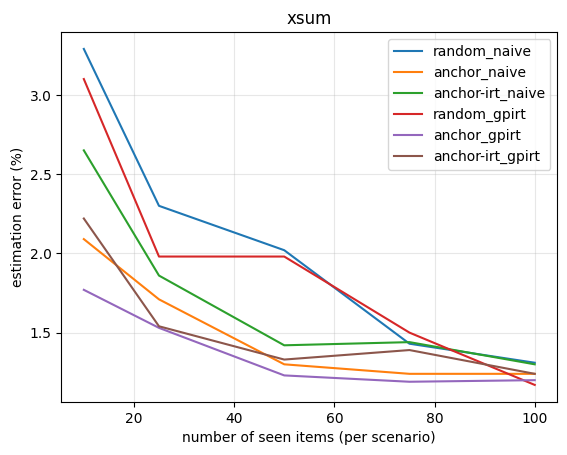

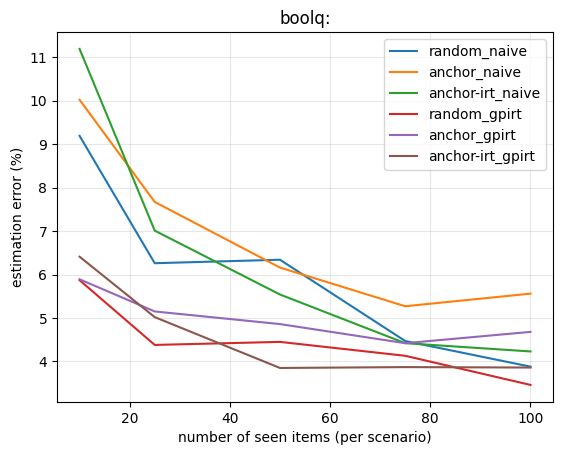

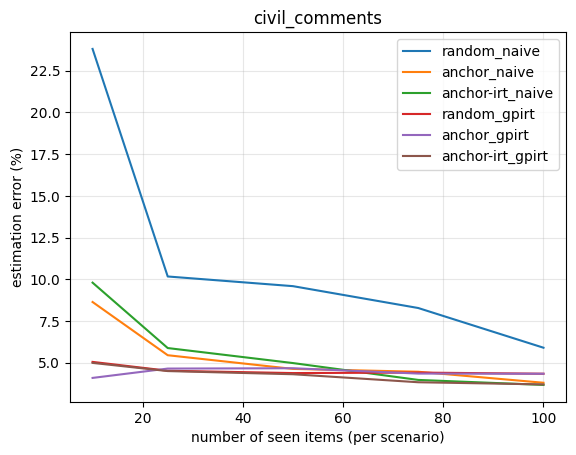

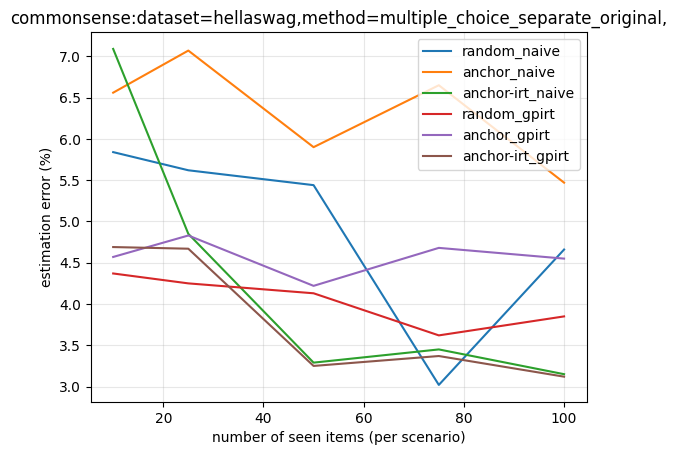

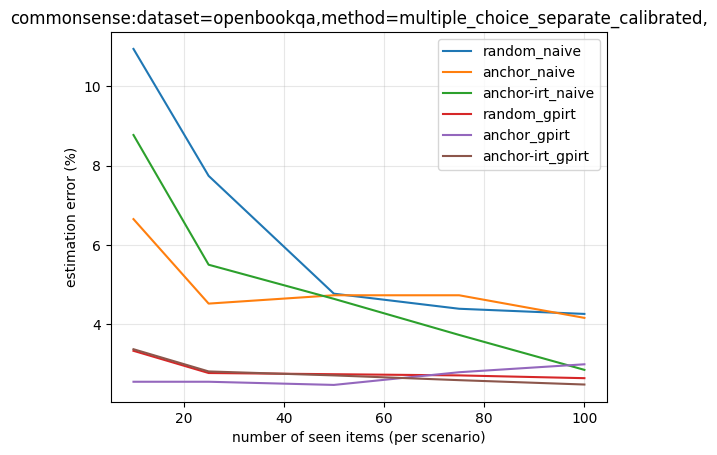

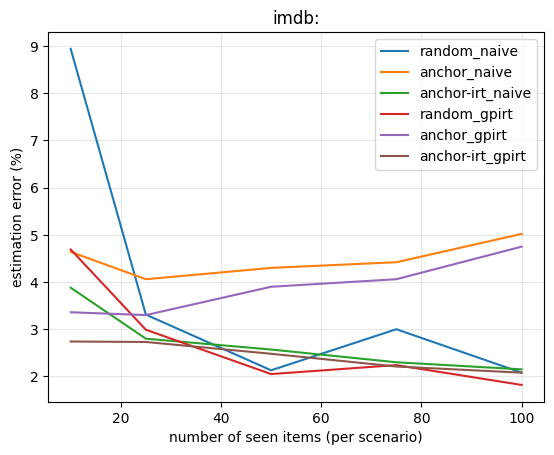

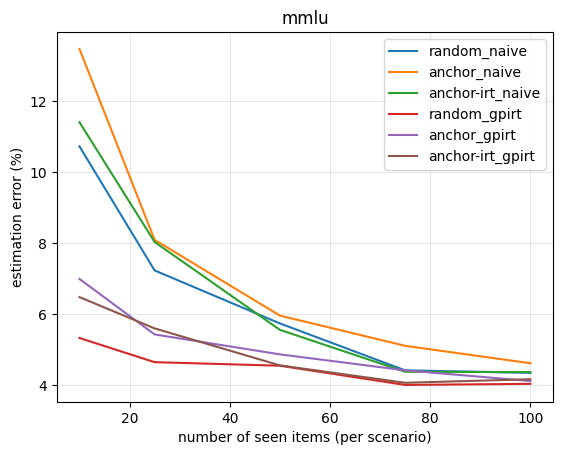

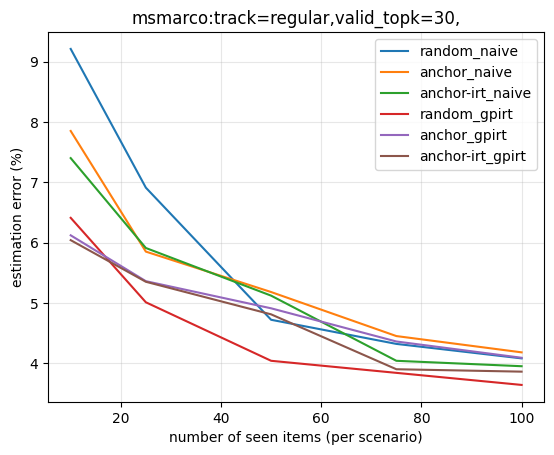

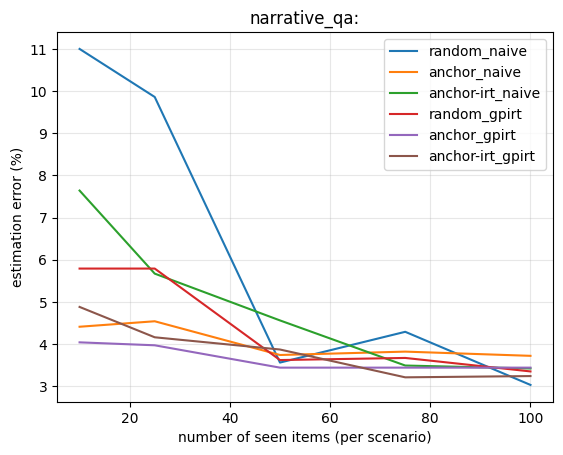

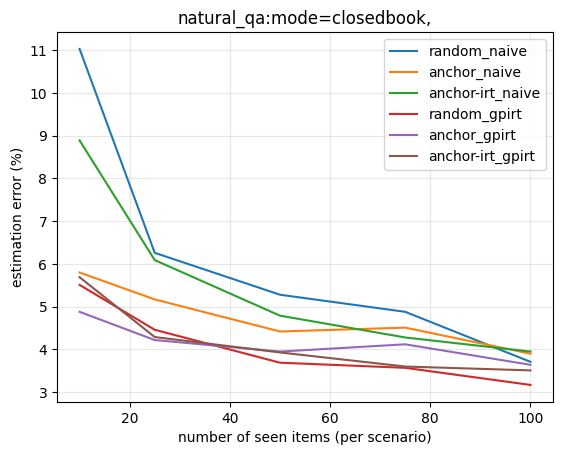

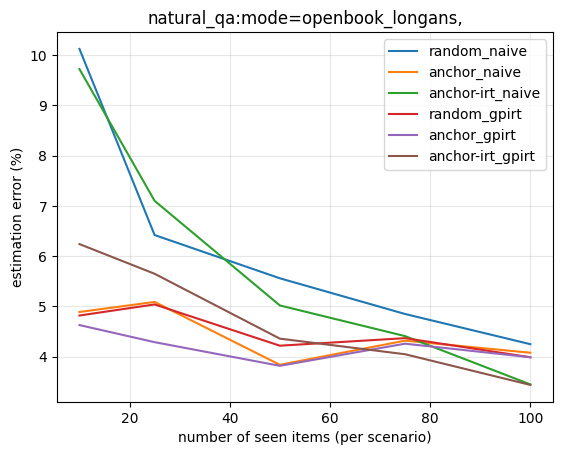

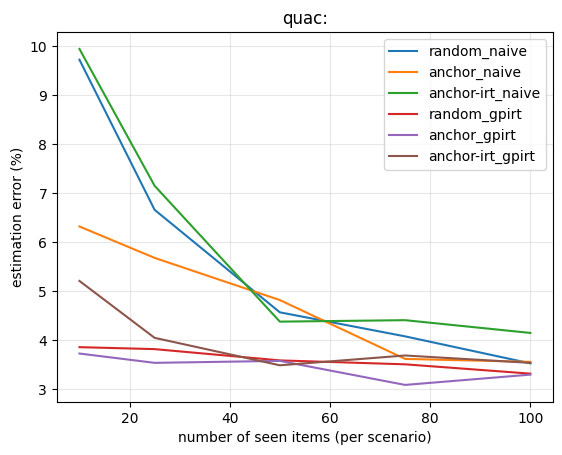

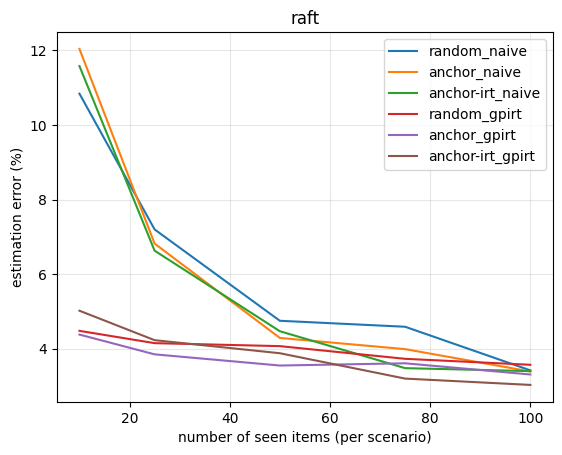

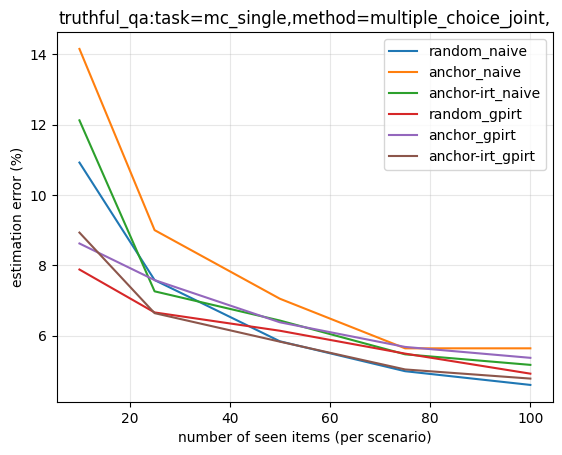

In [16]:
for s,scenario in enumerate(chosen_scenarios):
    pd.DataFrame(pd.DataFrame(table_avg[scenario])).plot()
    plt.grid(alpha=.3)
    plt.title(scenario)
    plt.ylabel('estimation error (%)')
    plt.xlabel('number of seen items (per scenario)')
    plt.show()

In [17]:
table_avg = {}
table_std = {}

for method in methods:
    table_avg[method]= {}
    table_std[method]= {}

    for number_item in number_items:
        acc_hat = np.array([[accs_full[model][number_item][method][scenario] for model in models] for scenario in chosen_scenarios])
        out = np.array([[np.abs(acc[s]-acc_hat[s,:,i]).mean() for s,_ in enumerate(chosen_scenarios)] for i in range(acc_hat.shape[2])]).mean(axis=0)
        table_avg[method][number_item] = np.round((100*out).mean(),2)
        table_std[method][number_item] = np.round((100*out).std(),2)

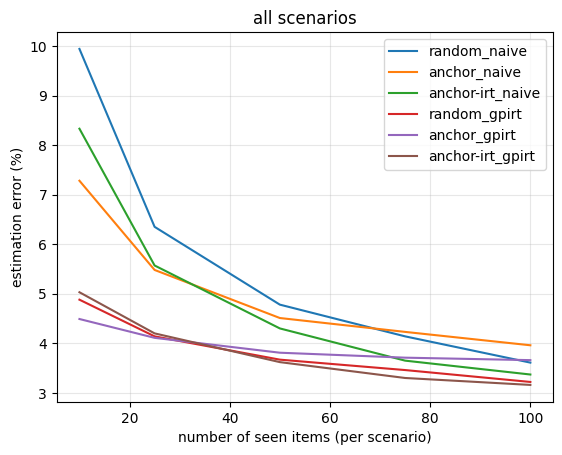

In [18]:
pd.DataFrame(table_avg).plot()
plt.grid(alpha=.3)
plt.title('all scenarios')
plt.ylabel('estimation error (%)')
plt.xlabel('number of seen items (per scenario)')
plt.show()

In [19]:
table_avg = {}
table_std = {}

for s,scenario in enumerate(chosen_scenarios):
    table_avg[scenario]= {}
    table_std[scenario]= {}
        
    for method in methods:
        table_avg[scenario][method]= {}
        table_std[scenario][method]= {}

        for number_item in number_items:
            acc_hat = np.array([accs_full[model][number_item][method][scenario] for model in models])
            out = np.array([stats.spearmanr(acc[s], acc_hat[:,i]).statistic for i in range(acc_hat.shape[1])]).mean(axis=0)
            table_avg[scenario][method][number_item] = np.round((100*out),2)
            table_std[scenario][method][number_item] = np.round((100*out),2)

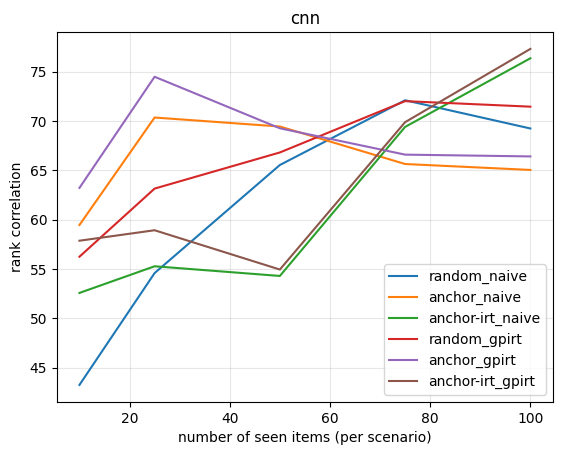

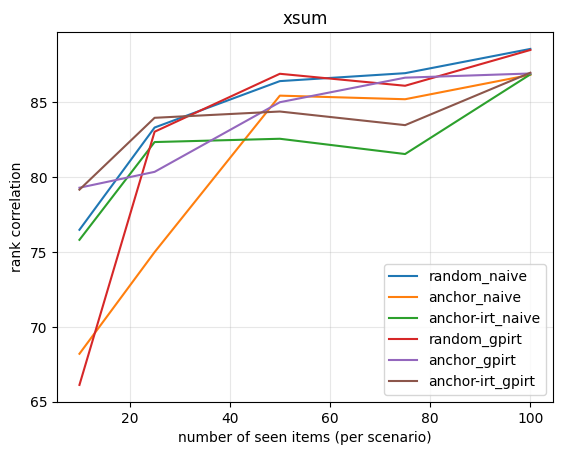

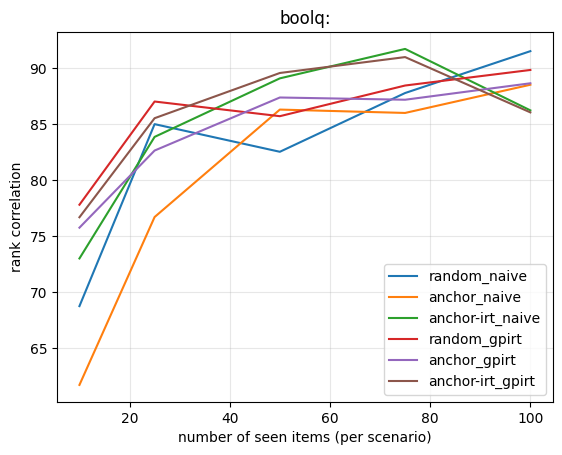

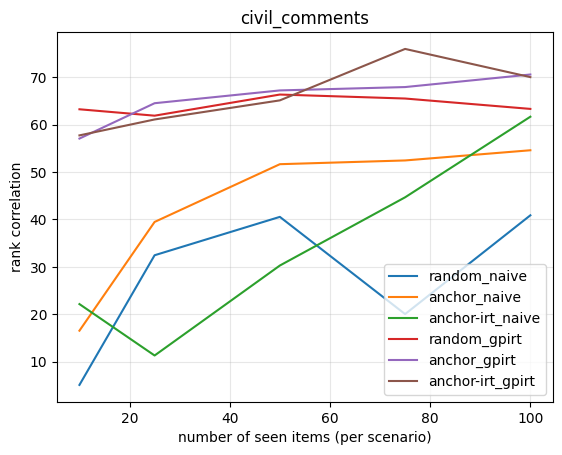

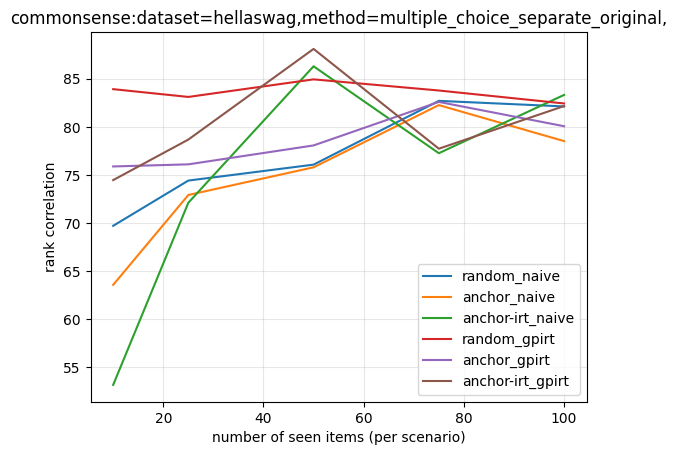

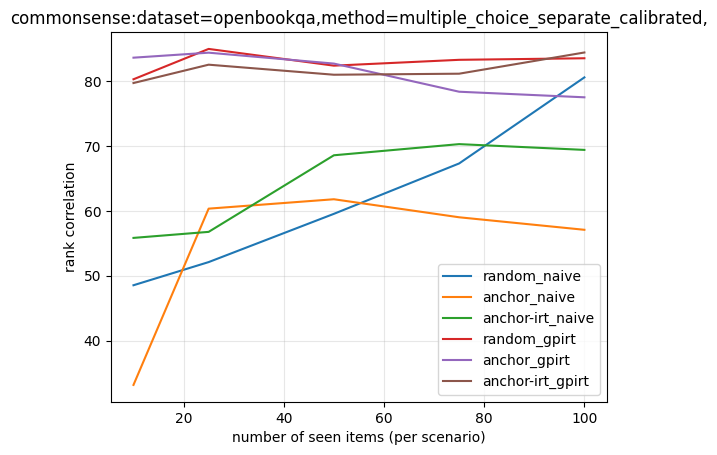

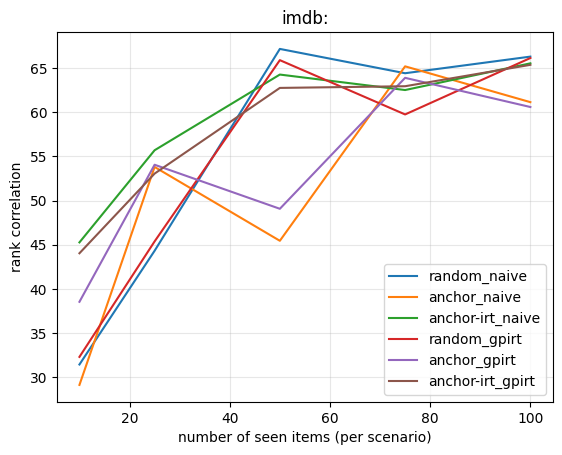

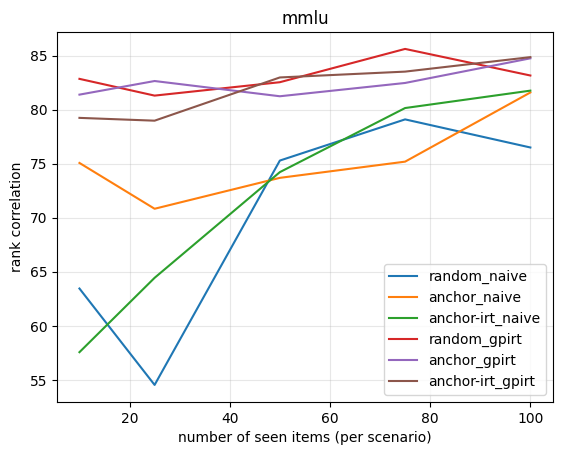

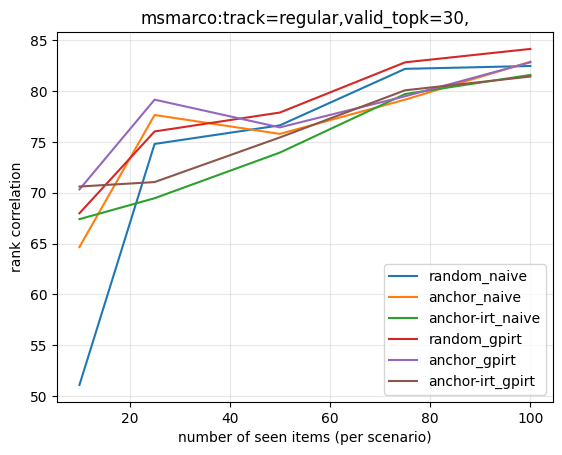

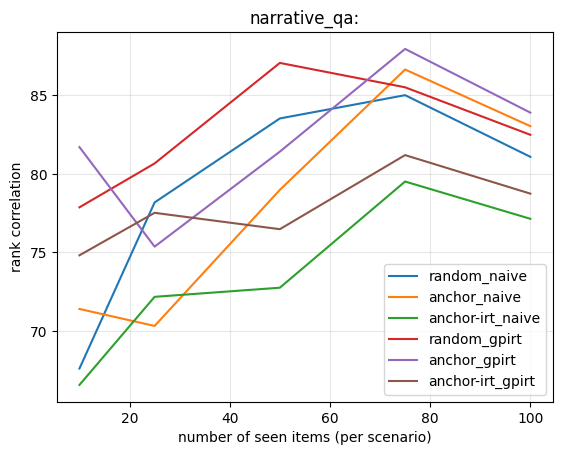

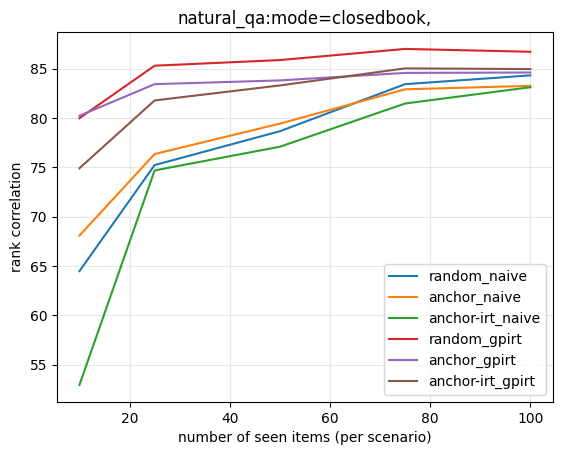

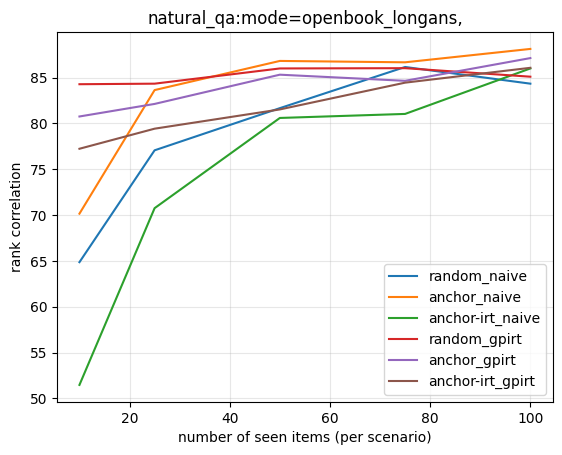

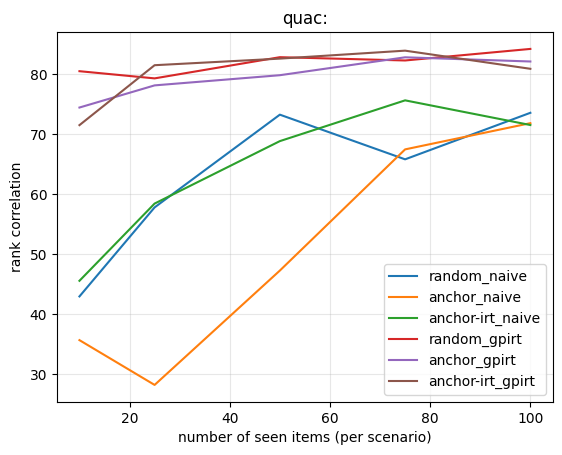

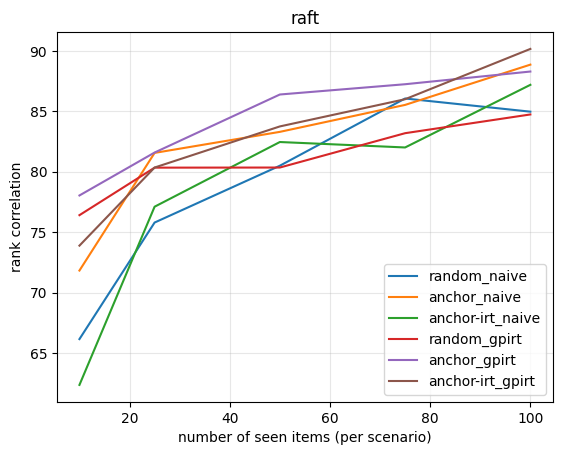

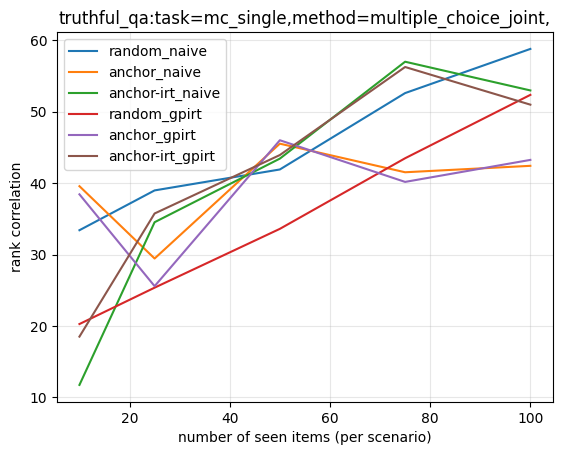

In [20]:
for s,scenario in enumerate(chosen_scenarios):
    pd.DataFrame(pd.DataFrame(table_avg[scenario])).plot()
    plt.grid(alpha=.3)
    plt.title(scenario)
    plt.ylabel('rank correlation')
    plt.xlabel('number of seen items (per scenario)')
    plt.show()

In [24]:
table_avg = {}
table_std = {}

for method in methods:
    table_avg[method]= {}
    table_std[method]= {}

    for number_item in number_items:
        acc_hat = np.array([[accs_full[model][number_item][method][scenario] for model in models] for scenario in chosen_scenarios])
        out = np.array([[stats.spearmanr(acc[s], acc_hat[s,:,i]).statistic for s,_ in enumerate(chosen_scenarios)] for i in range(acc_hat.shape[2])]).mean(axis=0)
        table_avg[method][number_item] = np.round((100*out).mean(),2)
        table_std[method][number_item] = np.round((100*out).std(),2)

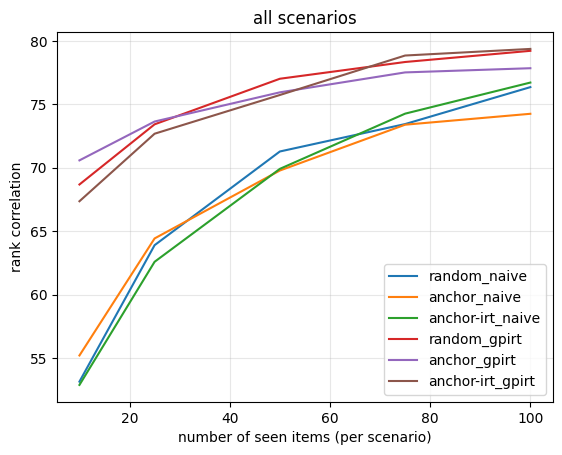

In [27]:
pd.DataFrame(table_avg).plot()
plt.grid(alpha=.3)
plt.title('all scenarios')
plt.ylabel('rank correlation')
plt.xlabel('number of seen items (per scenario)')
plt.show()

In [26]:
table_avg

{'random_naive': {10: 53.15, 25: 63.9, 50: 71.28, 75: 73.44, 100: 76.35},
 'anchor_naive': {10: 55.21, 25: 64.43, 50: 69.78, 75: 73.39, 100: 74.25},
 'anchor-irt_naive': {10: 52.89, 25: 62.59, 50: 69.91, 75: 74.26, 100: 76.71},
 'random_gpirt': {10: 68.68, 25: 73.42, 50: 77.01, 75: 78.33, 100: 79.21},
 'anchor_gpirt': {10: 70.58, 25: 73.64, 50: 75.94, 75: 77.51, 100: 77.84},
 'anchor-irt_gpirt': {10: 67.36, 25: 72.68, 50: 75.73, 75: 78.84, 100: 79.36}}